# model

In [1]:
import numpy as np
from scipy.special import softmax

NSTATES = 9
MAX_SCH = 41

class SchemaTabularBayes():
    """ CRP prior
    tabluar predictive distirbution
    """

    def __init__(self,concentration,stickiness_wi,stickiness_bt,sparsity,
        lrate=1,lratep=1,pvar=0,decay_rate=1,schidx=None):
        self.Tmat = np.zeros([NSTATES,NSTATES])
        self.alfa = concentration
        self.beta_wi = stickiness_wi
        self.beta_bt = stickiness_bt - np.abs(pvar*np.random.randn(1)[0])
        self.lrate = lrate # lrate like
        self.lratep = lratep # lrate prior
        self.lmbda = sparsity
        self.ntimes_sampled = 0
        self.schidx = schidx
        self.decay_rate = decay_rate

    def get_prior(self,beta_mode,ztm1,ztrm1):
        """ beta_mode controls whether to combine betas or use separate
        ztm1 : z of tstep t minus 1
        ztrm1 : z of trial t minus 1
        """
        if self.ntimes_sampled == 0:
            return self.alfa
        ztm1_flag = ztm1 == self.schidx
        ztrm1_flag = ztrm1 == self.schidx
        if beta_mode == 0: # beta within only
            crp = self.lratep*self.ntimes_sampled + self.beta_wi* ztm1_flag
        elif beta_mode == 1: # beta between only
            assert ztm1 == ztrm1
            crp = self.lratep*self.ntimes_sampled + self.beta_bt* ztm1_flag
        elif beta_mode == 2: # combined
            crp = self.lratep*self.ntimes_sampled + \
                    self.beta_bt*ztrm1_flag + self.beta_wi*ztm1_flag
        return crp

    def get_like(self,xtm1,xt):
        PARAM_S = 2
        num = self.lmbda + self.Tmat[xtm1,xt]
        den = (PARAM_S*self.lmbda) + self.Tmat[xtm1,:].sum()
        like = num/den
        return like

    def update(self,xtm1,xt):
        self.Tmat[xtm1,xt]+=self.lrate
        return None

    def decay(self):
        self.Tmat = self.Tmat*self.decay_rate
        return None

    def predict(self,xtm1):
        """ returns un-normalized count """
        xthat = np.array([
            self.get_like(xtm1,x) for x in range(NSTATES)
            ])
        return xthat


class SEM():

    def __init__(self,schargs,beta2,skipt1=True,ppd_allsch=False):
        self.SchClass = SchemaTabularBayes
        self.schargs = schargs
        self.beta2_flag = beta2
        self.skipt1 = skipt1
        self.ppd_allsch = ppd_allsch
        self.init_schlib()

    def init_schlib(self):
        """ 
        initialize with two schemas
        one active one inactive
        """
        sch0 = self.SchClass(**self.schargs,schidx=0)
        sch1 = self.SchClass(**self.schargs,schidx=1)
        self.schlib = [sch0,sch1]
        return None

    def decay_allsch(self):
        for sch in self.schlib:
            sch.decay()
        return None

    def get_beta_mode(self):
        if self.tstep==0: 
            return 1 # between only
        elif self.beta2_flag:
            return 2 # between+within
        else:
            return 0 # within only
        return None

    def calc_posteriors(self,xtm1,xt,ztm,ztrm,active_only=False):
        """ loop over schema library
        """
        beta_mode = self.get_beta_mode()
        if active_only: # prediction
            priors = [sch.get_prior(beta_mode,ztm,ztrm) for sch in self.schlib if sch.ntimes_sampled>0]
            likes = [sch.get_like(xtm1,xt) for sch in self.schlib if sch.ntimes_sampled>0]
            # print(self.tstep,likes)
        else: # sch inference
            priors = [sch.get_prior(beta_mode,ztm,ztrm) for sch in self.schlib]
            likes = [sch.get_like(xtm1,xt) for sch in self.schlib]
            # record 
            self.data['prior'][self.tridx,self.tstep,:len(priors)] = priors
            self.data['like'][self.tridx,self.tstep,:len(likes)] = likes
        posteriors = [p*l for p,l in zip(priors,likes)]
        return posteriors

    def select_sch(self,xtm1,xt,ztm,ztrm):
        """ xt and xtm1 are ints
        """
        posteriors = self.calc_posteriors(xtm1,xt,ztm,ztrm)
        self.data['post'][self.tridx,self.tstep,:len(posteriors)] = posteriors
        active_k = np.argmax(posteriors)
        if active_k == len(self.schlib)-1:
            self.schlib.append(self.SchClass(**self.schargs,schidx=len(self.schlib)))
        return active_k

    def predict(self,xtm1,ztm,ztrm):
        """ 
        """
        pr_xt_z = np.array([
            self.calc_posteriors(xtm1,x,ztm,ztrm,active_only=True
                ) for x in range(NSTATES)
            ]) # probability of each next state under each schema
        pr_xtp1 = np.sum(pr_xt_z,axis=1) # sum over schemas
        ## debug printing
        # if self.tstep==0:
        #     print(self.tridx)
        #     if self.tridx<=40:
        #         print('-sch0',pr_xt_z[1:3,0])
        #     elif self.tridx>40:
        #         print('-sch0',pr_xt_z[1:3,0])
        #         print('-sch1',pr_xt_z[1:3,1])
        #     # print(self.tridx,pr_xt_z.shape,pr_xt_z[:4,:].T)
        #     print('ppd',pr_xtp1[1:3])
        #     print('softmax',softmax(pr_xtp1[1:3]).round(4))
        # print(pr_xtp1)

        return pr_xtp1

    def run_exp(self,exp):
        """ exp is L of trialL
        trialL is L of obs (ints) 
        """
        ## recording
        Mt0ij = np.zeros([len(exp),NSTATES,NSTATES])
        self.data = data = {
            'zt':-np.ones([len(exp),len(exp[0])]),
            'xth':-np.ones([len(exp),len(exp[0]),NSTATES]),
            'prior':-np.ones([len(exp),len(exp[0]),MAX_SCH]),
            'like':-np.ones([len(exp),len(exp[0]),MAX_SCH]),
            'post':-np.ones([len(exp),len(exp[0]),MAX_SCH]),
        }
        ## 
        scht = schtm = schtrm = self.schlib[0] # sch0 is active to start
        scht.ntimes_sampled += 1
        for tridx,trialL in enumerate(exp):
            self.tridx = tridx
            for tstep,(xtm,xt) in enumerate(zip(trialL[:-1],trialL[1:])):
                # conditional
                if (tstep==1) and (self.skipt1): continue
                if len(self.schlib)>=MAX_SCH: return data
                # print('ts',tstep)
                self.tstep = tstep
                ## prediction: marginilize over schemas
                if self.ppd_allsch:
                    xth = self.predict(xtm,schtm.schidx,schtrm.schidx)
                else:
                    xth = scht.predict(xtm)
                ## prediction: only active schema
                # xth = scht.predict(xtm)
                # update infered active schema
                zt = self.select_sch(xtm,xt,schtm.schidx,schtrm.schidx)
                scht = self.schlib[zt]
                # print(tstep,scht.Tmat,self.data['likes'][:20,:,1])
                ## forgetting
                scht.decay()
                # update transition matrix
                scht.update(xtm,xt)
                scht.ntimes_sampled += 1
                # update schema history
                schtm = scht
                data['xth'][tridx][tstep] = xth
                data['zt'][tridx][tstep] = zt       
            # final schema of trial
            schtrm = scht 
        return data




class Task():
    """ 
    """

    def __init__(self):
        A1,A2,B1,B2 = self._init_paths_csw()
        self.paths = [[A1,A2],[B1,B2]]
        self.tsteps = len(self.paths[0][0])
        self.exp_int = None
        return None


    def _init_paths_csw(self):
        """ 
        begin -> locA -> node11, node 21, node 31, end
        begin -> locA -> node12, node 22, node 32, end
        begin -> locB -> node11, node 22, node 31, end
        begin -> locB -> node12, node 21, node 32, end
        """
        begin = 0 # E0
        locA,locB = 1,2 # E1
        node11,node12 = 3,4 # E2 
        node21,node22 = 5,6 # E3
        node31,node32 = 7,8 # E4
        end = 9
        A1 = np.array([begin,locA,
            node11,node21,node31
            ])
        A2 = np.array([begin,locA,
            node12,node22,node32
            ])
        B1 = np.array([begin,locB,
            node11,node22,node31
            ])
        B2 = np.array([begin,locB,
            node12,node21,node32
            ])
        return A1,A2,B1,B2

    def _init_paths_toy(self):
        """ 
        begin -> locA -> node11, node 21, node 31, end
        begin -> locA -> node12, node 22, node 32, end
        begin -> locB -> node11, node 22, node 31, end
        begin -> locB -> node12, node 21, node 32, end
        """
        locA,locB = 0,1
        node11,node12 = 2,3
        node21,node22 = 4,5
        A1 = np.array([locA,
            node11,node21
            ])
        A2 = np.array([locA,
            node12,node22
            ])
        B1 = np.array([locB,
            node11,node22
            ])
        B2 = np.array([locB,
            node12,node21
            ])
        return A1,A2,B1,B2


    def get_curriculum(self,condition,n_train,n_test):
        """ 
        order of events
        NB blocked: ntrain needs to be divisible by 4
        """
        curriculum = []   
        if condition == 'blocked':
            assert n_train%4==0
            curriculum =  \
                [0] * (n_train // 4) + \
                [1] * (n_train // 4) + \
                [0] * (n_train // 4) + \
                [1] * (n_train // 4 )
        elif condition == 'early':
            curriculum =  \
                [0] * (n_train // 4) + \
                [1] * (n_train // 4) + \
                [0, 1] * (n_train // 4)
        elif condition == 'middle':
            curriculum =  \
                [0, 1] * (n_train // 8) + \
                [0] * (n_train // 4) + \
                [1] * (n_train // 4) + \
                [0, 1] * (n_train // 8)
        elif condition == 'late':
            curriculum =  \
                [0, 1] * (n_train // 4) + \
                [0] * (n_train // 4) + \
                [1] * (n_train // 4)
        elif condition == 'interleaved':
            curriculum = [0, 1] * (n_train // 2)
        elif condition == 'single': ## DEBUG
            curriculum =  \
                [0] * (n_train) 
        else:
            print('condition not properly specified')
            assert False
        # 
        curriculum += [int(np.random.rand() < 0.5) for _ in range(n_test)]
        return np.array(curriculum)


    def generate_experiment(self,condition,n_train,n_test):
        """ 
        exp: arr [ntrials,tsteps]
        curr: arr [ntrials]
        """
        # get curriculum
        n_trials = n_train+n_test
        curr = self.get_curriculum(condition,n_train,n_test)
        # generate trials
        exp = -np.ones([n_trials,self.tsteps],dtype=int)
        for trial_idx in range(n_train+n_test):
            # select A1,A2,B1,B2
            event_type = curr[trial_idx]
            path_type = np.random.randint(2)
            path_int = self.paths[event_type][path_type]
            # embed
            exp[trial_idx] = path_int
        return exp,curr

# utils

In [ ]:
FLAG_SMACC = False

In [2]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
from scipy.special import softmax
from itertools import product
import time
import seaborn as sns
sns.set_context('talk')

# from model import *
# ## import human data for fitting
# hdf = pd.read_csv('../human_data.csv')
# humanB_acc,humanI_acc = hdf.loc[:,('blocked mean','interleaved mean')].values.T


def softmax_custom(x,tau):
    return np.exp(x*tau)/np.sum(np.exp(x*tau))
  
  
def get_sm(xth,norm=True):
  """ 
  given x_t_hat from subject
  [trial,layer,node]
  get 2afc normalized softmax for layer 2/3
  return: [layer2/3,trial,node56/78]
  norm=true 
   apply softmax to xth
   when prediction done with multiple schemas
  """
  nodes = {2:(5,6),3:(7,8)} 
  L = [] # layer 2 and 3
  for l,ns in nodes.items():
    y = xth[:,l,ns]
    if norm:
      # y=softmax(y,1)
      y = np.array([softmax_custom(yt,3) for yt in y])
    L.append(y)
  return np.array(L)

def get_acc(data,acc_mode=FLAG_SMACC):
    """ 
    returns 2afc softmax of 
    layer 2/3 transitions
    single seed
    """
    if acc_mode: # compute softmax acc
        ysm = get_sm(data['xth'])
        # print(data['xth'],ysm)
        L = []
        # loop over layers
        for i in range(2):
            ysml = ysm[i,:,:]
            yt = data['exp'][:,i+3] 
            pr_yt = ysml[range(len(ysml)),yt - (5+2*i)] # 
            L.append(pr_yt)
        return np.array(L)
    else: # compute score
        xth = data['xth']
        resp = xth.argmax(-1)
        exp = data['exp']
        score = resp[:,2:4] == exp[:,3:5]
        # transpose required for backcompatibility
        return score.T


def unpack_acc(cbatch_data):
    """ 
    given cbatch data (data from multiple curr and seeds)
    return acc [curr,seed,trial]
    """
    accL = [] # curr
    for cidx in range(len(cbatch_data)):
        acc = np.array([get_acc(sbatch) for sbatch in cbatch_data[cidx]])
        accL.append(acc.mean(1)) # mean over layers
    return np.array(accL)

def unpack_data(cbatch_data,dtype='priors'):
    """ unpacks batch data from multiple curr and seeds
    dtype: priors,likes,post
    """
    L = []
    for cidx in range(len(cbatch_data)):
        L.append([])
        for sidx,sbatch_data in enumerate(cbatch_data[cidx]):
            # print(sidx,sbatch_data[dtype].shape)
            # assert False
            mask = np.any(sbatch_data[dtype]!=-1,0)[0]
            # print(mask)
            L[cidx].append(sbatch_data[dtype][:,:,mask])
    return L


### RUN EXP
def run_batch_exp(ns,args):
  """ exp over seeds, 
  single task_condition / param config
  return full data
  """
  dataL = []
  for i in range(ns):
    task = Task()
    sem = SEM(schargs=args['sch'],**args['sem'])
    exp,curr  = task.generate_experiment(**args['exp'])
    data = sem.run_exp(exp)
    data['exp']=exp
    dataL.append(data)
  return dataL



def run_batch_exp_curr(ns,args,currL=['blocked','interleaved']):
  """ loop over task conditions, 
  return acc [task_condition,seed,trial]
  """
  accL = []
  dataL = []
  # dataD = {}
  for curr in currL:
    args['exp']['condition'] = curr
    ## extract other data here
    data_batch = run_batch_exp(ns,args)
    dataL.append(data_batch)
    # dataD[curr] = dataL
    ## unpack seeds and take mean over layers
    acc = np.array([get_acc(data) for data in data_batch]).mean(1) # mean over layer
    accL.append(acc)
  return dataL

## plotting


# runtime

In [3]:
from matplotlib import pyplot as plt
from scipy.special import softmax
from itertools import product
import numpy as np

import time
import seaborn as sns
sns.set_context('talk')

%load_ext autoreload
%reload_ext autoreload
%autoreload 2
%matplotlib inline

testaccconcentration_210.000-stickiness_wi_300.000-stickiness_bt_400.000-sparsity_1.500-pvar_0.000-lrate_1.000-lratep_1.000-decay_rate_1.000-beta2_0.000

In [4]:
## default params
expargs = {
  'condition':'blocked',
  'n_train':160,
  'n_test':40
}
schargs = {
   'concentration':1.4,
   'stickiness_wi':3,
   'stickiness_bt':3,
   'sparsity':0.11,
   'pvar': 0,
   'lrate':1,
   'lratep':1,
   'decay_rate':1,
}
semargs = {
  'beta2':False,
  'skipt1':True,
  'ppd_allsch':False
}
args = {
    'sem':semargs,
    'sch':schargs,
    'exp':expargs
}
param_str = "-".join(["%s_%.3f"%(i,j) for i,j in schargs.items()])
param_str += "-"+"-".join(["%s_%.3f"%(i,j) for i,j in semargs.items()])
param_str

'concentration_1.400-stickiness_wi_3.000-stickiness_bt_3.000-sparsity_0.110-pvar_0.000-lrate_1.000-lratep_1.000-decay_rate_1.000-beta2_0.000-skipt1_1.000-ppd_allsch_0.000'

In [5]:
# p_name = 'concentration' # 
# p_vals = np.arange(0.1,2.5,0.2)

# p_name = 'stickiness_wi' # 5000
# p_vals = np.arange(0,10000,500)

# p_name = 'stickiness_bt' # 100
# p_vals = np.arange(0,20,1)

# p_name = 'sparsity' # 0.08
# p_vals = np.arange(0.01,0.5,0.05)

# p_name = 'pvar' # 0
# p_vals = np.arange(1,2,0.1)

# p_name = 'lrate' # 1
# p_vals = np.arange(0.1,1,0.05)

p_name = 'lratep' # 1
p_vals = np.arange(0.98,1.01,0.01)

# p_name = 'decay_rate' # 1
# p_vals = np.arange(0.99,1.01,0.0005)

p_name,p_vals

('lratep', array([0.98, 0.99, 1.  , 1.01]))

In [13]:
def pltsave_macc(macc,schargs=None,labL=['B','I','E','M','L'],close=True):
  """ 
  save accuracy of individual parameter setting 
  used in paramsearch loops
  """
  plt.figure(figsize=(10,4))
  ax=plt.gca()
  for idx in range(len(macc)):
    ax.plot(macc[idx],label=labL[idx])
  ax.axhline(0.5,c='k')
  plt.legend()
  param_str = "-".join(["%s_%.3f"%(i,j) for i,j in schargs.items()])
#   plt.savefig('figures/scratch_folders/%i/acc-%s.jpg'%(tstamp,param_str))
  if close:
    plt.close('all')
  return None

def calc_adjrand(exp_batch_data):
  from sklearn.metrics import adjusted_rand_score
  arscores = -np.ones([len(condL),ns,3])
  for curr_idx in range(5):
    for seed_idx in range(ns):
      for t_idx,tstep in enumerate([0,2,3]):
        arscores[curr_idx,seed_idx,t_idx] = adjusted_rand_score(
          exp_batch_data[curr_idx][seed_idx]['exp'][:,1],
          exp_batch_data[curr_idx][seed_idx]['zt'][:,tstep]
        )
  return arscores.mean(1)


In [23]:
ns = 1
dfL = []
condL = ['blocked','interleaved','early','middle','late']
acc = -np.ones([len(p_vals),len(condL),200])
for idx,p_val in enumerate(p_vals):
  print('\n',p_name,p_val)
  
  args['sch'][p_name] = p_val  
  exp_batch_data = run_batch_exp_curr(ns,args,condL)
  ## acc
  batch_acc = unpack_acc(exp_batch_data) # curr,seeds,trials
  mean_acc = batch_acc.mean(1)
  acc[idx] = mean_acc # param,curr,trial
  test_acc = mean_acc[:,-40:].mean(1) # curr  
  
  
  #sch counts
  scha=np.array([[len(np.unique(exp_batch_data[i][c]['zt'])
  ) for c in range(ns)] for i in range(5)])
  print('counts B I E M L')
  print(scha.mean(1))
  
  # adjrand
  arand = calc_adjrand(exp_batch_data)
  print('adjusted rand')
  print(arand.T.round(3))
  
  ## record
  gsD = {
    **schargs,
    **dict(zip(condL,test_acc))
  }
  dfL.append(gsD)
  
gsdf = pd.DataFrame(dfL)


 lratep 0.98
counts B I E M L
[3. 3. 3. 3. 3.]
adjusted rand
[[1. 1. 1. 1. 1.]
 [1. 1. 1. 1. 1.]
 [1. 1. 1. 1. 1.]]

 lratep 0.99
counts B I E M L
[3. 3. 3. 3. 3.]
adjusted rand
[[1. 1. 1. 1. 1.]
 [1. 1. 1. 1. 1.]
 [1. 1. 1. 1. 1.]]

 lratep 1.0
counts B I E M L
[3. 3. 3. 3. 3.]
adjusted rand
[[ 1.     1.     1.     1.     1.   ]
 [ 1.    -0.005  1.     0.228  0.182]
 [ 1.     0.268  1.     0.228  0.182]]

 lratep 1.01
counts B I E M L
[3. 3. 3. 3. 3.]
adjusted rand
[[1. 1. 1. 1. 1.]
 [1. 1. 1. 1. 1.]
 [1. 1. 1. 1. 1.]]


Text(0.5, 1.0, 'concentration_1.400-stickiness_wi_3.000-stickiness_bt_3.000-sparsity_0.110-pvar_0.000-lrate_1.000-lratep_1.000-decay_rate_1.000-beta2_0.000-skipt1_1.000-ppd_allsch_0.000')

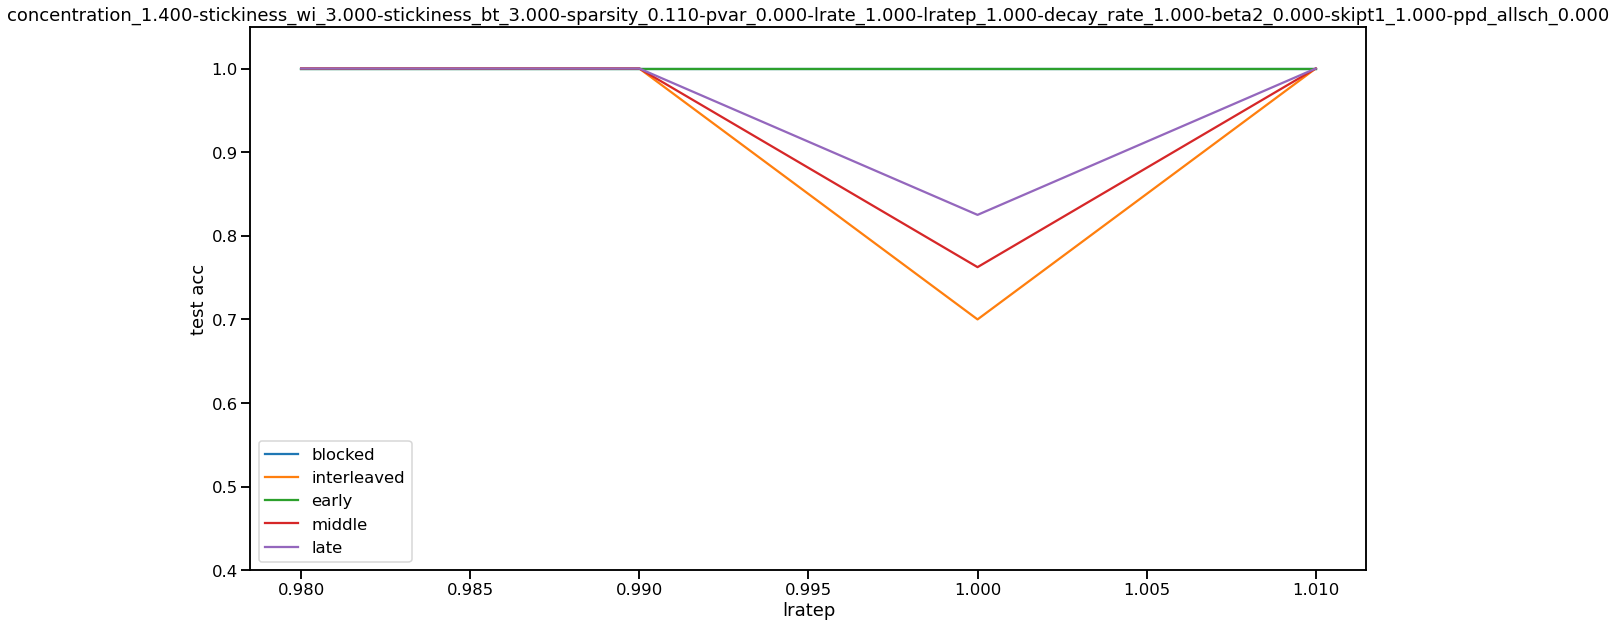

In [8]:
plt.figure(figsize=(20,10))
ax = plt.gca()
gsdf.plot(p_name,condL,ax=ax)
ax.set_ylim(0.4,1.05)
ax.set_ylabel('test acc')
plt.title(param_str)
# plt.savefig('figures/scratch/testacc-sweep_%s-default_%s-t%s.png'%(
#   p_name,param_str,tstamp))

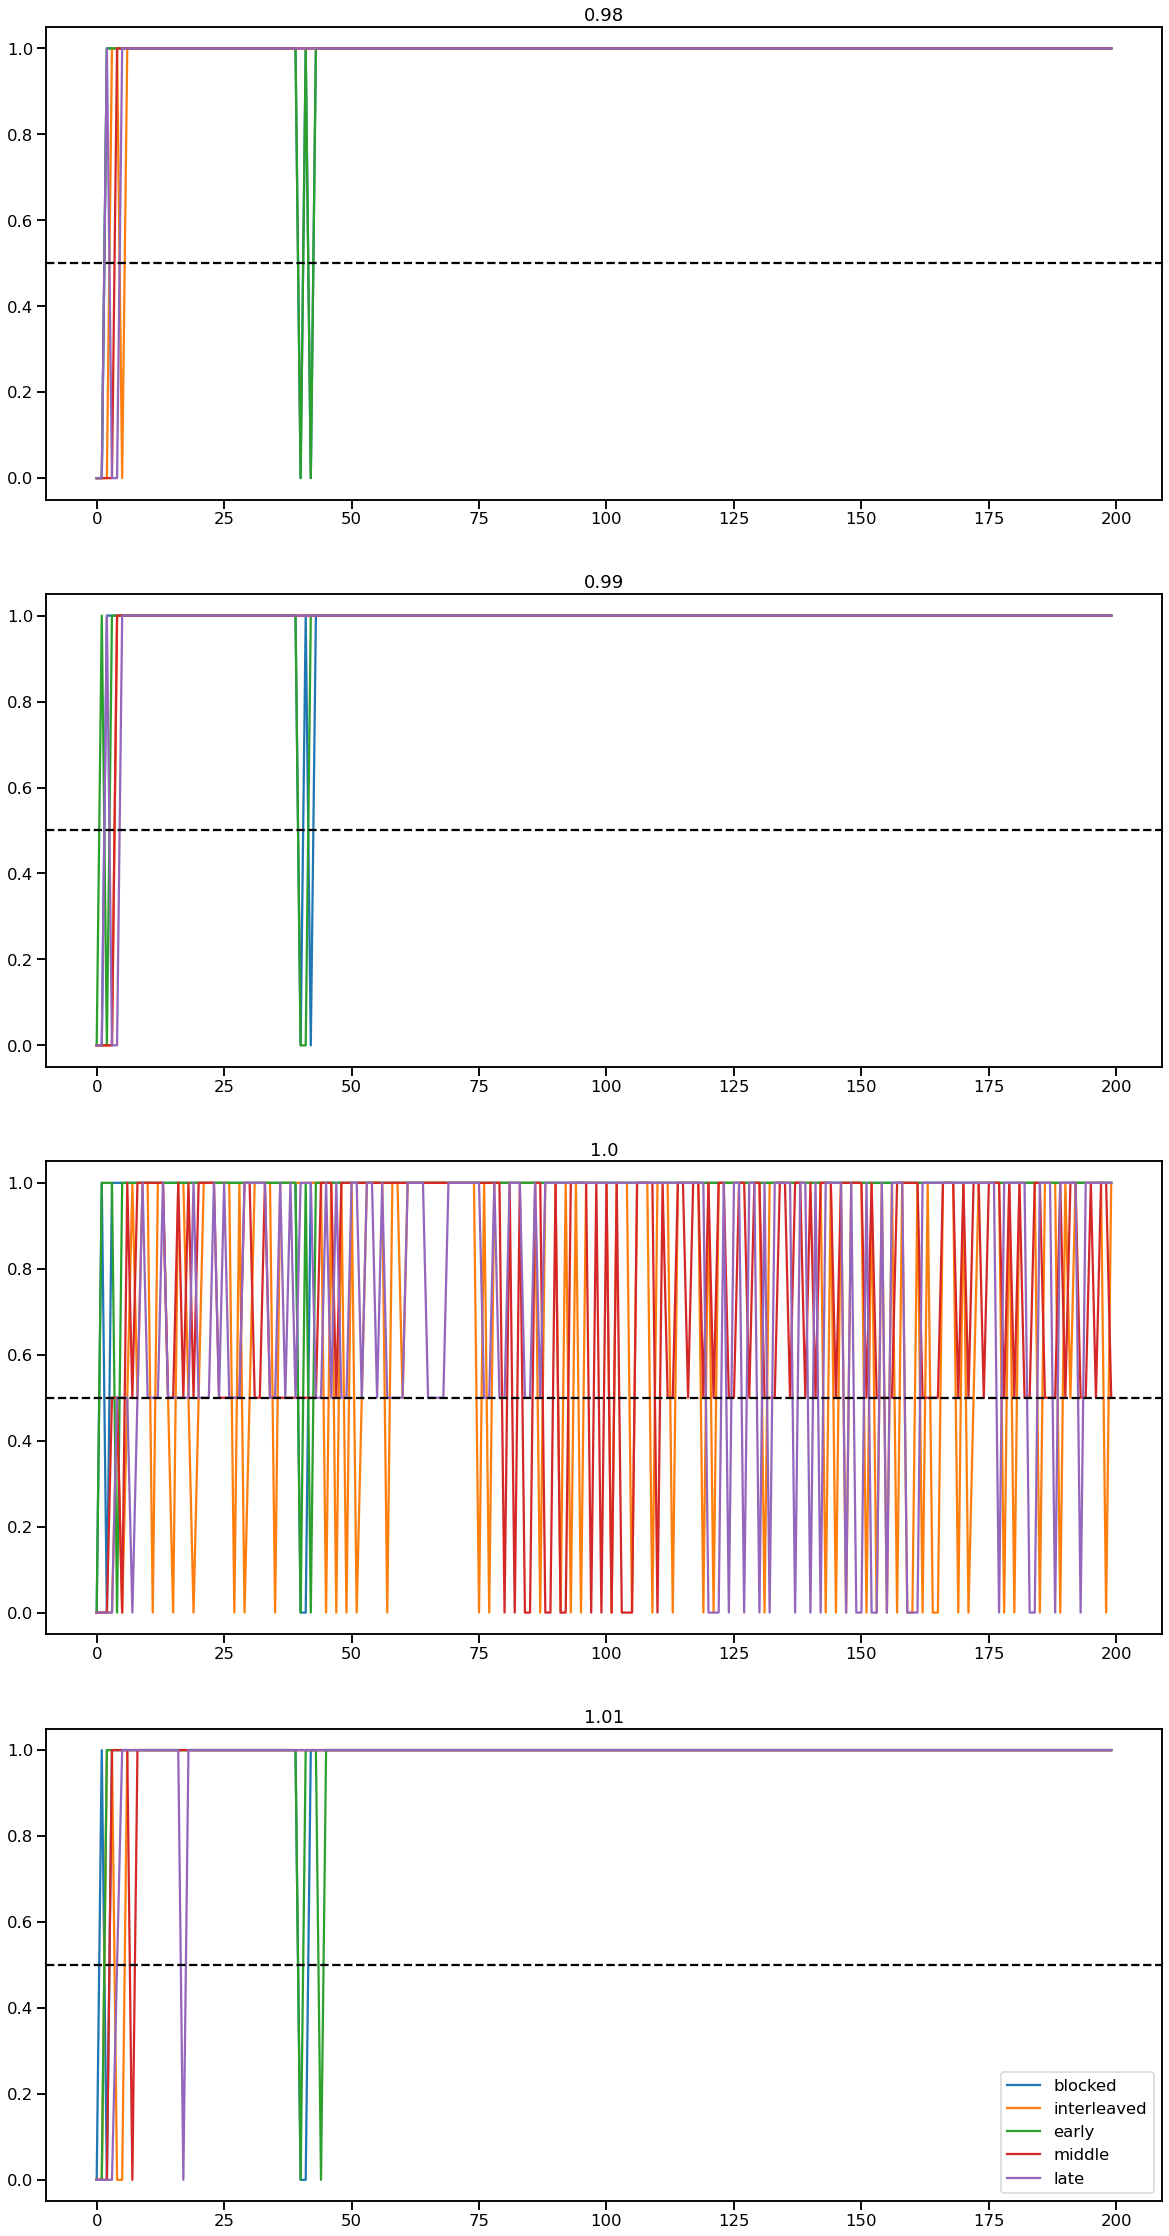

In [9]:
f,axar = plt.subplots(len(acc),1,figsize=(20,len(acc)*10))
for ia in range(len(acc)):
  ax = axar[ia]
  ac = acc[ia]
  ax.set_title(p_vals[ia])
  for ic in range(len(ac)):
    ax.plot(ac[ic],label=condL[ic])
  ax.axhline(0.5,c='k',ls='--')
ax.legend()